In [2]:
# import libraries we need
%pylab inline
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

Populating the interactive namespace from numpy and matplotlib


*This is for simulating correlation data using Monte Carlo.*

First, we make random choice to decide which light source is used.

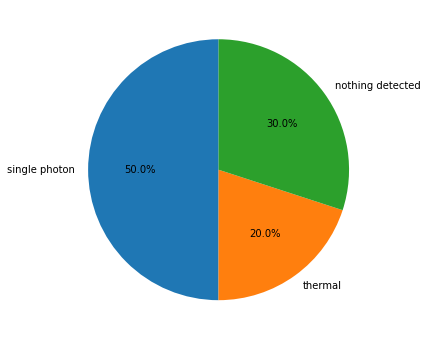

In [51]:
# determine which the light source for each detection

Ndetection = int(10e6)    # number of detections
p_sps = 0.5         #  probability of detecting a single photon source
p_thermal = 0.2      # probability of detecting a thermal light source
p_non = 0.3         # probability of getting nothing / 2nd photon is not in the range of abs time range
source = tf.random.categorical(tf.math.log([[p_sps,p_thermal,p_non]]), Ndetection)

fig,ax = plt.subplots()
ax.pie([len(np.where(source[0].numpy()==i)[0])for i in range(3)],
       labels=['single photon','thermal','nothing detected'],autopct='%1.1f%%',startangle=90)

#plt.polar(source[0].numpy(),label='event')
#plt.ylabel('event type',fontsize=15)
#plt.xticks([0,1,2],['single photon','thermal','nothing'])
#plt.legend(loc=(0,1.02))
plt.show()

---

Next, we simulate the single photon source case.

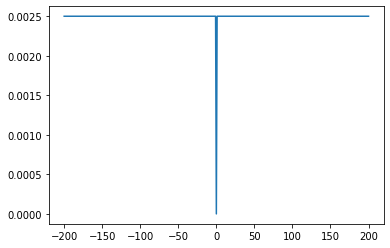

In [4]:
total_bin = 401     # number of total time bins
bin_array = tf.range(total_bin//2 * (-1) ,total_bin//2+1,delta=1,dtype=float32)
bin_n = tf.constant(np.linspace(min(bin_array),-1,total_bin//2),dtype=float32)
bin_p = tf.constant(np.linspace(1,max(bin_array),total_bin//2),dtype=float32)

sps_dist = tfd.MixtureSameFamily(
    mixture_distribution = 
    tfd.Categorical(probs=[bin_n.shape[0]/(total_bin-1),0, bin_p.shape[0]/(total_bin-1)]),
    
    components_distribution = 
    #tfd.Uniform(low=[min(bin_array),-1,1],high=[-1,1,max(bin_array)])
    tfd.Uniform(low=[min(bin_array),10000.,1],high=[0,10000.,max(bin_array)+1])
                       )

sps_prob = sps_dist.prob(bin_array+0.1)
#sps_prob = tf.concat([sps_prob[0],[0],sps_prob[1]],0)
plt.plot(bin_array,sps_prob)
#plt.xlim(-2,2)
plt.show()


### test it

In [5]:
counts = 10e6
#samples = tf.cast(sps_dist.sample(counts),dtype=int32)
samples = sps_dist.sample(counts)

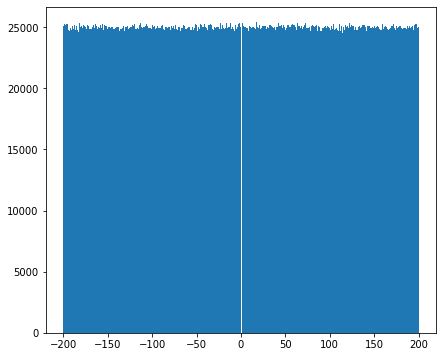

In [6]:
plt.figure(figsize(7,6))
histoinfo=plt.hist(samples.numpy(), bins=np.ndarray.tolist(bin_array.numpy()) )   #np.ndarray.tolist(bin_array.numpy()) )
#plt.xlim(-5,5)

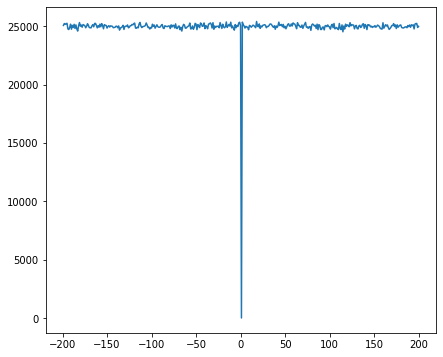

In [7]:
plt.plot(histoinfo[1][1:],histoinfo[0][0:])
#plt.xlim(-2,3)

---
The case no photon is detected, which is trivial.

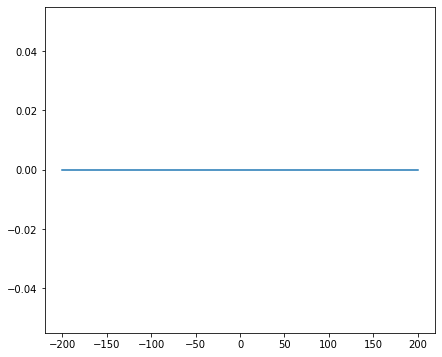

In [8]:
# no photons detected

non_dist = tfd.Uniform(low=10000.,high=10000.)
non_prob = non_dist.prob(bin_array)
#non_prob = tf.concat([non_prob[0],non_prob[1]],0)
plt.plot(bin_array,non_prob)
plt.show()


---
A thermal light source.

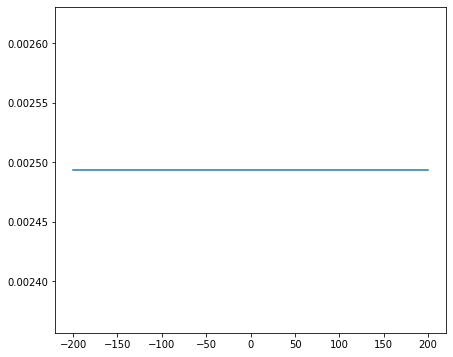

In [9]:
ther_dist = tfd.Uniform(low=min(bin_array),high=max(bin_array)+1)
ther_prob = ther_dist.prob(bin_array)
#non_prob = tf.concat([non_prob[0],non_prob[1]],0)
plt.plot(bin_array,ther_prob)
plt.show()


In [10]:
counts = Ndetection
samples = ther_dist.sample(counts)

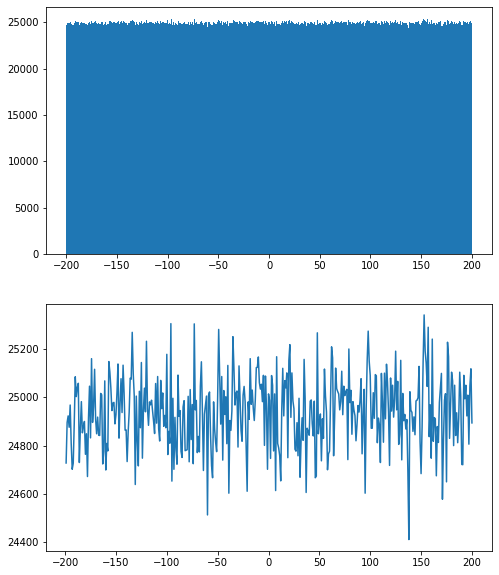

In [11]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
histoinfo=plt.hist(samples.numpy(), bins=np.ndarray.tolist(bin_array.numpy()) ) 
plt.subplot(2,1,2)
plt.plot(histoinfo[1][1:],histoinfo[0][0:])


---
What about a perfectly coherent laser?
    

---
Combine above situations

In [12]:
total_dist = tfd.Mixture(
    cat = tfd.Categorical(probs=[p_sps,p_non,p_thermal]),
    components = [sps_dist,non_dist,ther_dist] )

simu_samples = total_dist.sample(counts)

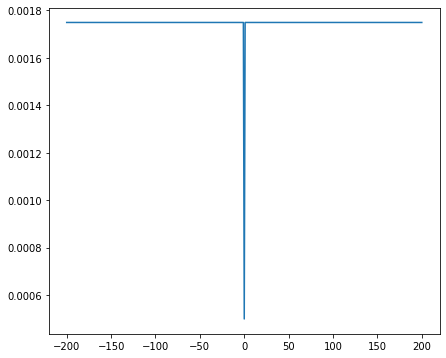

In [13]:
plt.plot(bin_array,total_dist.prob(bin_array+0.1))

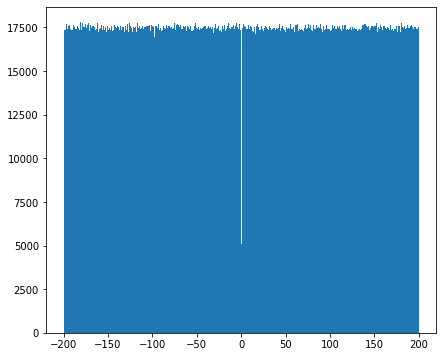

In [14]:
histoinfo_total=plt.hist(simu_samples.numpy(), bins=np.ndarray.tolist(bin_array.numpy()) )
#plt.savefig('sps')
#plt.xlim(-10,20)

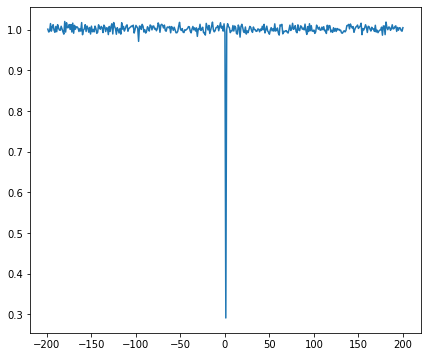

In [15]:
# normalize it
plt.plot(histoinfo_total[1][1:],histoinfo_total[0][0:]/np.average(histoinfo_total[0][:Ndetection//2-1]))
#plt.savefig('sps_')

### check plt.hist

In [16]:
min(bin_info[1],bin_info[0])

NameError: name 'bin_info' is not defined

In [ ]:
a=bin_info[0][0:]
b=bin_info[1][1:]
b[a==0]

In [ ]:
x=np.random.uniform(low=-10,high=10,size=10000)
k=plt.hist(x,bins=np.ndarray.tolist(np.arange(-10,11) ))

In [ ]:
k

In [ ]:
plt.scatter(np.arange(10000),x)

In [ ]:
x1=np.random.random_integers(low=2,high=10,size=100)
plt.hist(x1,bins=8)

In [ ]:
int(-200.3)

In [ ]:
import tensorflow_probability as tfp
tfd = tfp.distributions

# Define a single scalar Normal distribution.
dist = tfd.Normal(loc=0., scale=3.)

# Evaluate the cdf at 1, returning a scalar.
dist.cdf(1.)

# Define a batch of two scalar valued Normals.
# The first has mean 1 and standard deviation 11, the second 2 and 22.
dist = tfd.Normal(loc=[-2, 2.], scale=[1.,1])

# Evaluate the pdf of the first distribution on 0, and the second on 1.5,
# returning a length two tensor.
dist.prob([-2.,2])

# Get 3 samples, returning a 3 x 2 tensor.
#dist.sample([5])


In [ ]:
# samples has shape [1, 5], where each value is either 0 or 1 with equal
# probability.
samples = tf.random.categorical([[pthermal,psps,pnon]], 50)
plt.scatter(np.arange(50),samples[0])

In [ ]:
samples.numpy()

In [ ]:
six_way_multinomial = tfd.Multinomial(total_count=1000., probs=[.3, .25, .2, .15, .08, .02])
six_way_multinomial.log_prob([500., 100., 100., 150., 100., 50.])


In [ ]:
#six_way_multinomial.log_prob([[500., 100., 100.], [150., 100., 50.]])
tfb = tfp.bijectors
transformed_multinomial = tfd.TransformedDistribution(
    distribution=six_way_multinomial,
    bijector=tfb.Reshape(event_shape_out=[2, 3]))
transformed_multinomial.log_prob([[500., 100., 100.], [150., 100., 50.]])